# グローバーのアルゴリズム

このセクションでは、Grover のアルゴリズムと、それを使用して非構造化検索の問題を解決する方法を紹介します。次に、Qiskit を使用して実際の問題に Grover のアルゴリズムを実装し、シミュレーターと実際のデバイスで実行します。

## コンテンツ

1. [序章](#introduction)
    1.1[アルゴリズムの概要](#overview)
    1.2[グローバーのステップバイステップ](#steps)
    1.3[状態の準備](#state-prep)
    1.4[オラクル](#oracle)
    1.5[拡散演算子](#diffusion)
2. [例: 2 量子ビット](#2qubits)
    2.1[シミュレーション](#2qubits-simulation)
    2.2[デバイス](#2qubits-device)
3. [例: 3 量子ビット](#3qubits)
    3.1[シミュレーション](#3qubits-simulation)
    3.2[デバイス](#3qubits-device)
4. [問題点](#problems)
    4.1[グローバーのアルゴリズムを使用して数独を解く](#sudoku)
    4.2[グローバーのアルゴリズムを使用した三角形問題の解決](#tri)
5. [参考文献](#references)


## 1. はじめに<a id="introduction"></a>

量子コンピューターが古典的なコンピューターに比べて持つ多くの利点の 1 つは、データベースの検索速度が優れているということを聞いたことがあるでしょう。グローバーのアルゴリズムはこの機能を示しています。このアルゴリズムは非構造化検索問題を二次関数的に高速化できますが、その用途はそれを超えています。これは、他のさまざまなアルゴリズムの二次実行時間を改善するための一般的なトリックまたはサブルーチンとして機能します。これは振幅増幅トリックと呼ばれます。

$N$ 項目の大きなリストが与えられたとします。これらのアイテムの中には、特定したいユニークなプロパティを持つアイテムが 1 つあります。これを勝者 $w$ と呼びます。リスト内の各項目は、特定の色のボックスと考えてください。リスト内のすべての項目が、勝者の $w$ (紫色) を除いて灰色であるとします。

![画像1](images/grover_list.png)

従来の計算を使用して紫色のボックス (*マークされたアイテム)*を見つけるには、これらのボックスの平均 $N/2$ をチェックする必要があり、最悪の場合はすべての $N$ をチェックする必要があります。しかし、量子コンピュータでは、グローバーの振幅増幅トリックを使用して、およそ $\sqrt{N}$ ステップでマークされたアイテムを見つけることができます。確かに、二次関数の高速化により、長いリストからマークされた項目を見つけるのに大幅な時間が節約されます。さらに、アルゴリズムはリストの内部構造を使用しないため、*汎用的になります。*これが、多くの古典的な問題に対して直ちに 2 次量子の高速化を実現する理由です。


### 1.1 アルゴリズムの概要<a id="overview"></a>

Grover のアルゴリズムは、状態の準備、オラクル、拡散演算子の 3 つの主要なアルゴリズム ステップで構成されます。状態の準備では検索スペースを作成します。これは、答えが取り得るすべてのケースです。上で説明したリストの例では、検索スペースはそのリストのすべての項目になります。
オラクルは、正しい答え、または私たちが探している答えをマークするものであり、拡散演算子はこれらの答えを拡大して、アルゴリズムの最後で目立つようにして測定できるようにします。

![画像2](images/grover_steps.png)

では、アルゴリズムはどのように機能するのでしょうか?アイテムのリストを見る前は、マークされたアイテムがどこにあるのかわかりません。したがって、その位置の推測は他の推測と同じくらい正確であり、一様な重ね合わせで表すことができます: $|s \rangle = \frac{1}{\sqrt{N}} \sum_{x = 0} ^{N -1} | x \rangle.$

この時点で、標準基底 $ { | で測定するとします。 x \rangle } $ の場合、この重ね合わせは、第 5 量子法則に従って、$\frac{1}{N} = \frac{1}{2^n} の同じ確率で基底状態のいずれか 1 つに崩壊します。 $。したがって、予想どおり、正しい値 $w$ が $2^n$ の $1$ であると推測できる可能性があります。したがって、正しい項目を推測するには、平均して約 $N/2 = 2^{n-1}$ 回試行する必要があります。

振幅増幅と呼ばれる手順を入力します。これは、量子コンピューターがこの確率を大幅に高める方法です。この手順により、マークされた項目の振幅が引き伸ばされ (増幅され)、他の項目の振幅が縮小されるため、最終状態を測定すると、ほぼ確実に正しい項目が返されます。

このアルゴリズムは、2 次元平面内で回転を生成する 2 つの反射に関して優れた幾何学的解釈を備えています。考慮する必要がある特別な状態は 2 つだけであり、勝者 $| w \rangle$ と一様な重ね合わせ $| \rangle$。これら 2 つのベクトルは、ベクトル空間 $\cssId{vspace}{\mathbb{C}^N}$ の 2 次元平面に広がります。 $| であるため、それらは完全に垂直ではありません。 w \rangle$ は振幅 $N^{-1/2}$ の重ね合わせでも発生します。ただし、これら 2 つのベクトルの範囲内にあり、$| に垂直な追加の状態 $|s'\rangle$ を導入することができます。 w \rangle$ は、$|s \rangle$ から $| を削除することによって取得されます。 w \rangle$ と再スケーリング。

**ステップ 1** : 振幅増幅手順は一様な重ね合わせ $| から始まります。 ■ \rangle$。$| から簡単に構築できます。 s \rangle = H^{\otimes} | 0 \rangle^n$ または別の対称エンタングル状態を使用します。

![画像3](images/grover_step1.jpg)

左側のグラフィックは、垂直ベクトル $|w\rangle$ と $|s'\rangle$ によって広がる 2 次元平面に対応しており、初期状態を $|s\rangle = \sin \theta | として表すことができます。 w \rangle + \cos \theta | s' \rangle,$ ここで $\theta = \arcsin \langle s | w \rangle = \arcsin \frac{1}{\sqrt{N}}$。右の図は、状態 $| の振幅を示す棒グラフです。 \rangle$。

**ステップ 2** : オラクル リフレクション $U_f$ を状態 $|s\rangle$ に適用します。

![画像4](images/grover_step2.jpg)

幾何学的には、これは $|s'\rangle$ に関する状態 $|s\rangle$ の反映に対応します。この変換は、$|w\rangle$ 状態の前の振幅が負になることを意味します。これは、平均振幅 (破線で示される) が低下することを意味します。

**ステップ 3** : ここで、状態 $|s\rangle$ について追加の反射 ($U_s$) を適用します。 $U_s = 2|s\rangle\langle s| - \mathbb{1}$。この変換は状態を $U_s U_f| にマップします。 s \rangle$ を実行し、変換を完了します。

![画像5](images/grover_step3.jpg)

2 つの反射は常に 1 つの回転に対応します。変換 $U_s U_f$ は、初期状態 $|s\rangle$ を勝者 $|w\rangle$ に近づくように回転させます。振幅バー図における反射 $U_s$ の作用は、平均振幅に関する反射として理解できます。最初の反射によって平均振幅が低下しているため、この変換により $|w\rangle$ の負の振幅が元の値の約 3 倍に増加し、他の振幅は減少します。次に**ステップ 2**に進み、アプリケーションを繰り返します。この手順を数回繰り返して、勝者を絞り込みます。

$t$ ステップの後、$|\psi_t\rangle$ 状態になります。 \psi_t \rangle = (U_s U_f)^t | \rangle.$

回転を何回適用する必要がありますか?おおよそ $\sqrt{N}$ 回転すれば十分であることがわかります。これは、状態 $| の振幅を見ると明らかになります。 \psi\rangle$。 $| の振幅が大きいことがわかります。 w \rangle$ は、アプリケーション $\sim t N^{-1/2}$ の数に応じて線形に増加します。ただし、確率ではなく振幅を扱っているため、ベクトル空間の次元は平方根として入力されます。したがって、この手順で増幅されるのは確率だけではなく振幅です。

回転数を計算するには、検索空間のサイズと探している答えの数を知る必要があります。最適な反復回数 $t$ を取得するには、次の方程式に従うことができます。

$$
t = \lfloor\frac{\pi}{4}\sqrt{\frac{N}{m}}\rfloor
$$

ここで、N は検索空間のサイズ、m は必要な回答の数です。

![画像6](images/grover_circuit_high_level.png)

&nbsp;

## 1.2 グローバーのステップバイステップ<a id="step"></a>

グローバーのアルゴリズムが実際にどのように機能するかを説明したので、その構成と各コンポーネントのさまざまなケースについてもう少し詳しく説明しましょう。

## 1.2.1 サーチスペースの準備<a id="state-prep"></a>

Grover のアルゴリズムの最初のステップは、初期状態の準備です。先ほど述べたように、検索スペースは、必要な答えを見つけるために検索する必要があるすべての可能な値です。この教科書の例では、「データベース」は、量子ビットが取り得るすべての計算基礎状態で構成されています。たとえば、量子ビットが 3 つある場合、リストは状態 $|000\rangle, |001\rangle になります。 、\dots |111\rangle$ (つまり、状態 $|0\rangle \rightarrow |7\rangle$)。したがって、この場合、検索空間のサイズは $N = 2^{3} = 8$ になります。

場合によっては、探索空間内で答えが保証されている範囲がわかっていれば、探索空間から冗長な基底を削除してアルゴリズムを高速化し、回路のサイズを縮小することができます。一般的に言えば、 [GHZ 状態](https://quantum-computing.ibm.com/composer/docs/iqx/example-circuits/ghz)、 [W 状態](https://quantum-computing.ibm.com/composer/docs/iqx/example-circuits/w-state)、[ディッケ状態](gloss:ds)など、[任意の対称状態](gloss:ss)を使用して状態を準備できます。

たとえば、4 量子ビットを使用して 1 つの答えを持つ問題を解決しようとしていて、アダマール ゲートを使用して状態を準備する (つまり、ヒルベルト空間を形成する) 場合、N は 16 になります。しかし、答えが範囲内にあることがわかっている場合は、N は 16 になります。常に 1 つの量子ビットのみが 1 の値を持つ場合、完全なヒルベルト空間の代わりに W 状態を使用して状態を準備できます。これにより、探索空間のサイズが 16 から 4 に、最適な反復回数 $t$ が 3 から 1 に減少しました。

## 1.2.2 Oracle の作成<a id="oracle"></a>

グローバーのアルゴリズムの 2 番目で最も重要なステップはオラクルです。オラクルはソリューションの状態に負のフェーズを追加するため、他のものから際立って評価されるようになります。つまり、計算ベースの任意の状態 $|x\rangle$ に対して次のようになります。

$$
U_\omega|x\rangle = \bigg\{
\begin{aligned}
\phantom{-}|x\rangle \quad \text{if} \; x \neq \omega \\
-|x\rangle \quad \text{if} \; x = \omega \\
\end{aligned}
$$

このオラクルは対角行列になり、マークされた項目に対応するエントリは負の位相になります。たとえば、量子ビットが 3 つあり、$\omega = \text$ の場合、オラクルには次の行列が含まれます。

$$
U_\omega =
\begin{bmatrix}
1 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 \\
0 &amp; 1 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 \\
0 &amp; 0 &amp; 1 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 \\
0 &amp; 0 &amp; 0 &amp; 1 &amp; 0 &amp; 0 &amp; 0 &amp; 0 \\
0 &amp; 0 &amp; 0 &amp; 0 &amp; 1 &amp; 0 &amp; 0 &amp; 0 \\
0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; -1 &amp; 0 &amp; 0 \\
0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 1 &amp; 0 \\
0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 0 &amp; 1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\\
\\
\\
\leftarrow \omega = \text{101}\\
\\
\\
\\
\end{aligned}
$$

グローバーのアルゴリズムが非常に強力なのは、問題をこの形式のオラクルに変換することがいかに簡単であるかということです。計算問題には、解を*見つける*のは難しいものの、解を*検証する*のは比較的簡単な問題が数多くあります。たとえば、すべてのルールが満たされていることを確認することで、[数独](https://en.wikipedia.org/wiki/Sudoku)の解決策を簡単に検証できます。これらの問題に対して、提案された解 $x$ を取り、$x$ が解ではない場合 ($x \neq \omega$)、$ を返す関数 $f$ を作成できます。有効な解の場合、f(x) = 1$ ($x = \omega$)。この場合、私たちのオラクルは次のように説明できます。

$$
U_\omega|x\rangle = (-1)^{f(x)}|x\rangle
$$

オラクルの行列は次の形式の対角行列になります。

$$
U_\omega =
\begin{bmatrix}
(-1)^{f(0)} &amp;   0         &amp; \cdots &amp;   0         \\
0           &amp; (-1)^{f(1)} &amp; \cdots &amp;   0         \\
\vdots      &amp;   0         &amp; \ddots &amp; \vdots      \\
0           &amp;   0         &amp; \cdots &amp; (-1)^{f(2^n-1)} \\
\end{bmatrix}
$$

<!-- ::: q-block.reminder -->

### 詳細

<summary>Grover Oracle の回路構成</summary><p>古典的な関数 $f(x)$ がある場合、それを次の形式の可逆回路に変換できます。</p>
<p></p>
<img alt="古典的な永久神託" src="images/grover_boolean_oracle.svg"><p> $|{-}\rangle$ 状態の「出力」量子ビットを初期化すると、位相キックバック効果により、これが Grover オラクルに変わります (Deutsch-Jozsa オラクルの仕組みと似ています)。 </p>
<p></p>
<img alt="Grover Oracle は古典的な可逆オラクルから構築されています" src="images/grover_phase_oracle.svg"><p>次に、補助 ($|{-}\rangle$) 量子ビットを無視します。</p>

<!-- ::: -->


## 1.2.3 拡散演算子<a id="diffusion"></a>

最後に、オラクルが正解を否定的にマークした後、拡散演算子であるグローバーのアルゴリズムの最後のステップになります。

拡散演算子の構築は、初期状態を準備するために何を使用するかによって決まります。一般に、拡散演算子は次のような構成になっています。

![画像7](images/grover_diff.png)

この章の次の部分では、$\omega$ が事前にわかっているオラクルの例を作成し、これらのオラクルが役立つかどうかを心配する必要はありません。この章の最後では、問題 (数独) を解決するためのオラクルを作成する短い例と、有名なグラフ問題である三角形発見問題について説明します。

## 2. 例: 2 量子ビット<a id="2qubits"></a>

まず、2量子ビットで実現される$N=4$のGroverアルゴリズムの場合を見てみましょう。この特定のケースでは、初期状態 $|s\rangle$ を勝者 $|w\rangle$[3] に回転させるのに必要な<b>回転は 1 回</b>だけです。

1. 上記の導入に従って、$N=4$ の場合、次のようになります。

    $$\theta = \arcsin \frac{1}{2} = \frac{\pi}{6}.$$

2. $t$ ステップの後、次のようになります。

    $$(U_s U_\omega)^t  | s \rangle = \sin \theta_t | \omega \rangle + \cos \theta_t | s' \rangle ,$$

    どこ

    $$\theta_t = (2t+1)\theta.$$

3. $| を取得するには\omega \rangle$ には $\theta_t = \frac{\pi}{2}$ が必要で、上に $\theta=\frac{\pi}{6}$ を挿入すると $t=1$ になります。これは、$t=1$ 回転後に検索された要素が見つかることを意味します。

次に、特定のオラクルを使用した例を見ていきます。

#### $\lvert \omega \rangle = \lvert 11 \rangle$ のオラクル

$\lvert w \rangle = \lvert 11 \rangle$ の場合を見てみましょう。この場合のオラクル $U_\omega$ は次のように動作します。

$$U_\omega | s \rangle = U_\omega \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle + |11\rangle \right) = \frac{1}{2}\left( |00\rangle + |01\rangle + |10\rangle - |11\rangle \right).$$

または：

$$
U_\omega =
\begin{bmatrix}
1 &amp; 0 &amp; 0 &amp; 0 \\
0 &amp; 1 &amp; 0 &amp; 0 \\
0 &amp; 0 &amp; 1 &amp; 0 \\
0 &amp; 0 &amp; 0 &amp; -1 \\
\end{bmatrix}
$$

これは制御された Z ゲートとして認識されるかもしれません。したがって、この例では、私たちのオラクルは単に制御された Z ゲートです。

![画像8](images/grover_circuit_2qbuits_oracle_11.svg)

#### 反射 $U_s$

回路を完成させるには、追加の反射 $U_s = 2|s\rangle\langle s| を実装する必要があります。 - \mathbb{1}$。これは $|s\rangle$ に関する反映であるため、$|s\rangle$ に直交するすべての状態に負の位相を追加したいと考えています。

これを行う 1 つの方法は、状態 $|s\rangle \rightarrow |0\rangle$ を変換する操作を使用することです。これは、各量子ビットに適用されるアダマール ゲートであることがすでにわかっています。

$$H^{\otimes n}|s\rangle = |0\rangle$$

次に、$|0\rangle$ に直交する状態に逆位相を追加する回路を適用します。

$$U_0 \frac{1}{2}\left( \lvert 00 \rangle + \lvert 01 \rangle + \lvert 10 \rangle + \lvert 11 \rangle \right) = \frac{1}{2}\left( \lvert 00 \rangle - \lvert 01 \rangle - \lvert 10 \rangle - \lvert 11 \rangle \right)$$

つまり、$\lvert 00 \rangle$ を除いて、各状態の符号が反転されます。簡単に検証できるように、$U_0$ を実装する 1 つの方法は次の回路です。

![|0周りの反射回路>](images/grover_circuit_2qbuits_reflection_0.svg)

最後に、状態 $|0\rangle \rightarrow |s\rangle$ を変換する操作を実行します (再び H ゲート)。

$$H^{\otimes n}U_0 H^{\otimes n} = U_s$$

$U_s$ の完全な回路は次のようになります。

![|s>周りの反射回路](images/grover_circuit_2qbuits_reflection.svg)

#### $\lvert w \rangle = |11\rangle$ の全回路

$N=4$ という特定のケースでは 1 回の回転のみが必要なので、上記のコンポーネントを組み合わせて $\lvert w \rangle = |11\rangle$ の場合の Grover アルゴリズムの完全な回路を構築できます。

![画像11](images/grover_circuit_2qubits_full_11.svg)

### 2.1 Qiskitの実装

ここで、$\lvert w \rangle = |11\rangle$ の上記の 2 量子ビットの場合の Grover のアルゴリズムを実装します。

In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

まず、2 つの量子ビットを持つ量子回路を準備します。

In [2]:
n = 2
grover_circuit = QuantumCircuit(n)

次に、上に示した回路のコマンドを書き出すだけです。まず、状態 $|s\rangle$ を初期化する必要があります。 (任意の数の量子ビットに対して) 一般的な関数を作成して、後で再度使用できるようにしましょう。

In [3]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

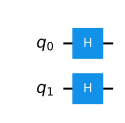

In [4]:
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

$|w\rangle = |11\rangle$ に Oracle を適用します。このオラクルは 2 量子ビットに固有です。

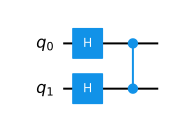

In [5]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw()

<span id="general_diffuser"></span>ここでディフューザー ($U_s$) を適用したいと思います。 $|s\rangle$ を初期化する回路と同様に、後で他の問題で使用できるように、一般的なディフューザー (任意の数の量子ビット用) を作成します。 

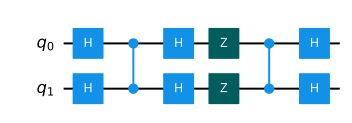

In [6]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

これが完成した回路です。

### 2.1.1 シミュレータによる実験<a id="2qubits-simulation"></a>

シミュレーションで回路を実行してみましょう。まず、正しい状態ベクトルがあることを確認します。

In [7]:
sv_sim = Aer.get_backend('statevector_simulator')
result = sv_sim.run(grover_circuit).result()
statevec = result.get_statevector()
from qiskit.visualization import array_to_latex
array_to_latex(statevec, prefix="|\\psi\\rangle =")

array([1.96261557e-16-2.46519033e-32j, 2.22044605e-16+1.22464680e-16j,
       1.96261557e-16+1.22464680e-16j, 1.00000000e+00-2.44929360e-16j])

予想どおり、$|11\rangle$ 以外のすべての状態の振幅は 0 です。これは、$|11\rangle$ を測定できる確率が 100% であることを意味します。

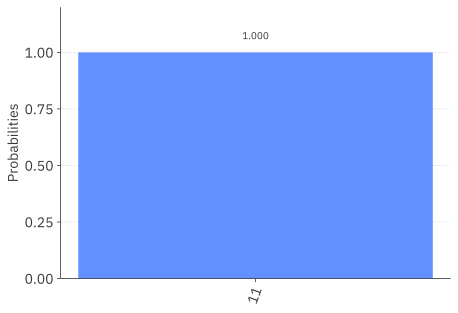

In [8]:
grover_circuit.measure_all()

qasm_sim = Aer.get_backend('qasm_simulator')
result = qasm_sim.run(grover_circuit).result()
counts = result.get_counts()
plot_histogram(counts)

### 2.1.2 実機での実験<a id="2qubits-device"></a>

以下のように実際のデバイス上で回路を実行できます。

In [9]:
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

Running on current least busy device:  ibmq_lima


In [10]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


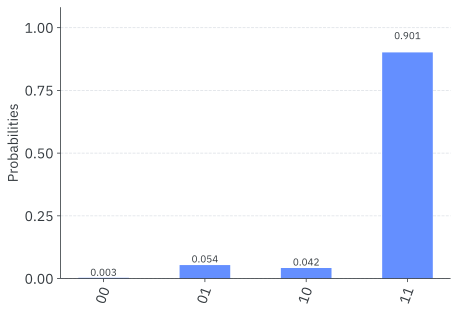

In [11]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

ほとんどの場合、状態 $|11\rangle$ が測定されることが確認されています。他の結果は、量子計算のエラーによるものです。

## 3. 例: 3 量子ビット<a id="3qubits"></a>

ここでは、参考文献 [2] にある実装に従って、$\lvert101\rangle$ と $\lvert110\rangle$ という 2 つのマークされた状態を持つ 3 量子ビットに対する Grover のアルゴリズムの例を見ていきます。位相オラクルを使用して問題を解決する量子回路は次のとおりです。

![画像12](images/grover_circuit_3qubits.png)

1. $\lvert000\rangle$ に初期化された $3$ 量子ビットにアダマール ゲートを適用して均一な重ね合わせを作成します。 $$\lvert \psi_1 \rangle = \frac{1}{\sqrt{8}} \left(
\lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle +
\lvert100\rangle + \lvert101\rangle + \lvert110\rangle + \lvert111\rangle \right)
$$

2. マークはフェーズオラクルを使用して $\lvert101\rangle$ と $\lvert110\rangle$ をステートします: $$\lvert \psi_2 \rangle = \frac{1}{\sqrt{8}} \left(
\lvert000\rangle + \lvert001\rangle + \lvert010\rangle + \lvert011\rangle +
\lvert100\rangle - \lvert101\rangle - \lvert110\rangle + \lvert111\rangle \right)
$$

3. 平均振幅付近で反射を実行します。

    1. アダマールゲートを量子ビットに適用$$
\lvert \psi_{3a} \rangle = \frac{1}{2} \left(
\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right)
$$

    2. Xゲートを量子ビットに適用$$
\lvert \psi_{3b} \rangle = \frac{1}{2} \left(
-\lvert000\rangle +\lvert011\rangle +\lvert100\rangle +\lvert111\rangle \right)
$$

    3. 1、2 (コントロール) と 3 (ターゲット) 量子ビットの間に二重制御 Z ゲートを適用します$$
\lvert \psi_{3c} \rangle = \frac{1}{2} \left(
-\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right)
$$

    4. Xゲートを量子ビットに適用$$
\lvert \psi_{3d} \rangle = \frac{1}{2} \left(
-\lvert000\rangle +\lvert011\rangle +\lvert100\rangle -\lvert111\rangle \right)
$$

    5. アダマールゲートを量子ビットに適用$$
\lvert \psi_{3e} \rangle = \frac{1}{\sqrt{2}} \left(
-\lvert101\rangle -\lvert110\rangle \right)
$$

4. $3$ 量子ビットを測定して状態 $\lvert101\rangle$ と $\lvert110\rangle$ を取得します

2 つの解と 8 つの可能性があるため、反復を 1 回実行するだけで済むことに注意してください (ステップ 2 と 3)。

### 3.1 Qiskitの実装<a id="3qubit-implementation"></a>

ここで、$3$-qubits に対する上記の[例の](#3qubits)Grover アルゴリズムを実装し、2 つのマークされた状態 $\lvert101\rangle$ と $\lvert110\rangle$ を検索します。**注:** Qiskit はこのリソースに対して逆方向に量子ビットを配置するため、描画された回路は水平方向に反転して表示されることに注意してください。

$\lvert101\rangle$ と $\lvert110\rangle$ を結果としてマークするフェーズ オラクルを作成します (ステップ 1)。

In [12]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

最後のセクションでは、2 量子ビットに固有のディフューザーを使用しました。下のセルでは、任意の数の量子ビットに対応する一般的なディフューザーを作成します。

<!-- ::: q-block.reminder -->

### 詳細

 <summary>一般的なディフューザーの作成</summary>$U_0$ から $U_s$ を作成できることを思い出してください。 $$ U_s = H^{\otimes n} U_0 H^{\otimes n} $$そして、マルチ制御 Z ゲート ($MCZ$) が位相を反転します。状態 $|11\dots 1\rangle$: $$
MCZ =
\begin{bmatrix}
1 & 0 & 0 & \cdots & 0 \\
0 & 1 & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & -1 \\
\end{bmatrix}
\begin{aligned}
\\
\\
\\
\leftarrow \text{Add negative phase to} \; |11\dots 1\rangle\\
\end{aligned}
$$各量子ビットに X ゲートを適用すると、次の変換が実行されます。 $$
\begin{aligned}
|00\dots 0\rangle & \rightarrow |11\dots 1\rangle\\
|11\dots 1\rangle & \rightarrow |00\dots 0\rangle
\end{aligned}
$$つまり: $$ U_0 = - X^{\otimes n} (MCZ) X^{\otimes n} $$これらのプロパティを一緒に使用すると、H ゲート、X ゲート、および$$ U_s = - H^{\otimes n} U_0 H^{\otimes n} = H^{\otimes n} X^{\otimes n} (MCZ) X^{\otimes n} H^{\otimes n} $$グローバル位相 -1 は無視できることに注意してください。

<!-- ::: -->

In [13]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

次に、回路の開始時に均一な重ね合わせを作成し、終了時に測定を行って、各部分を組み合わせます。 2 つの解と 8 つの可能性があるため、反復を 1 回実行するだけで済むことに注意してください。 

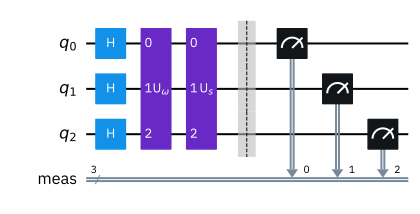

In [14]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

### 3.1.1 シミュレータによる実験<a id="3qubits-simulation"></a>

上記の回路をシミュレータ上で実行できます。 

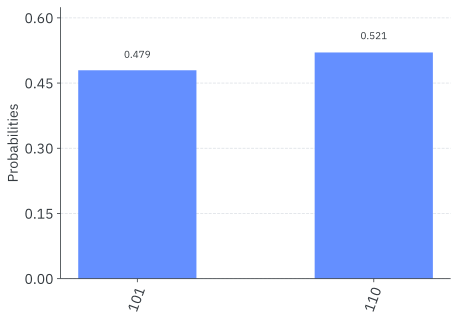

In [15]:
qasm_sim = Aer.get_backend('qasm_simulator')
transpiled_grover_circuit = transpile(grover_circuit, qasm_sim)
results = qasm_sim.run(transpiled_grover_circuit).result()
counts = results.get_counts()
plot_histogram(counts)

ご覧のとおり、アルゴリズムはマークされた状態 $\lvert101\rangle$ と $\lvert110\rangle$ を検出します。

### 3.1.2 実機での実験<a id="3qubits-device"></a>

以下のように実機上で回路を実行できます。

In [16]:
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_lima


In [17]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


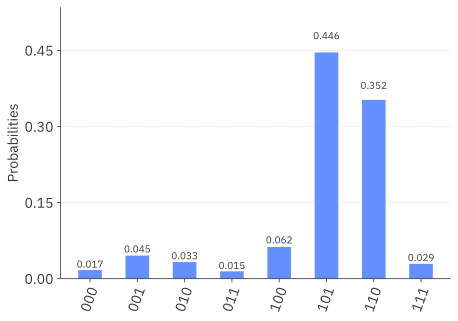

In [18]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

ご覧のとおり (おそらく)、$\lvert101\rangle$ と $\lvert110\rangle$ を測定する可能性が高くなります。他の結果は、量子計算のエラーによるものです。 

## 4. 問題点<a id="problems"></a>

以下の関数`grover_problem_oracle` 、量子ビットの数 ( `n` ) と`variant`を受け取り、n 量子ビットのオラクルを返します。この関数は、同じ`n`と`variant`に対して常に同じ oracle を返します。 `grover_problem_oracle`呼び出すときに`print_solutions = True`に設定すると、各 Oracle の解決策を確認できます。

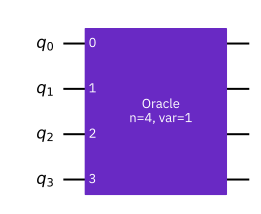

In [19]:
from qiskit_textbook.problems import grover_problem_oracle
## Example Usage
n = 4
oracle = grover_problem_oracle(n, variant=1)  # 0th variant of oracle, with n qubits
qc = QuantumCircuit(n)
qc.append(oracle, [0,1,2,3])
qc.draw()

1. `grover_problem_oracle(4, variant=2)` 4 量子ビットを使用し、解決策は 1 つあります。
     ａ．この解を 90% 以上の確率で測定するには何回の反復が必要ですか?
     b.グローバーのアルゴリズムを使用して、この解の状態を見つけます。 c.上記の問題 1a で計算した回数よりも多くの反復を適用するとどうなるでしょうか?なぜ？

2. 2 つの解と 4 量子ビットの場合、90% を超える確率で解を測定するには何回の反復が必要ですか? oracle `grover_problem_oracle(4, variant=1)` (2 つの解決策があります) を使用して答えをテストします。

3. 入力として受け取る関数`grover_solver(oracle, iterations)`を作成します。

    - ゲートとしての Grover オラクル ( `oracle` )
    - 整数の反復数 ( `iterations` )

    そして、' `oracle` ' ゲートでグローバーのアルゴリズムを ' `iterations` ' 回実行する`QuantumCircuit`を返します。

## 4.1 グローバーのアルゴリズムを使用して数独を解く<a id="sudoku"></a>

この章でこれまで使用されてきたオラクルは、その解決策についての事前知識をもとに作成されています。次に、グローバーのアルゴリズムを使用して単純な問題を解決しますが、この問題については必ずしも事前に解がわかっているわけではありません。私たちの問題は 2×2 のバイナリ数独です。この場合、それには 2 つの単純なルールがあります。

- どの列にも同じ値を 2 回含めることはできません
- どの行にも同じ値を 2 回含めることはできません

次のように数独の各正方形を変数に代入すると:

![2×2 バイナリ数独。各正方形が異なる変数に割り当てられます。](images/binary_sudoku.png)

私たちの回路がこの数独の解を出力するようにしたいと考えています。

グローバーのアルゴリズムを使用してこの問題を解決するこのアプローチは実用的ではありませんが (おそらく頭の中で解決策を見つけることができるでしょう!)、この例の目的は、古典的な[意思決定問題](https://en.wikipedia.org/wiki/Decision_problem)をグローバーのアルゴリズムのオラクルに変換することを示すことであることに注意してください。

### 4.1.1 問題を回路に変換する

この問題の解決に役立つオラクルを作成したいと考えており、正しい解決策を特定する回路を作成することから始めます。 [*『The Atoms of Computation』*](/course/ch-states/the-atoms-of-computation)で量子回路を使用して古典的な加算器を作成した方法と同様に、変数ビットの状態が有効な解であるかどうかをチェックする*古典的な*関数を量子回路上に作成するだけです。

両方の列と両方の行をチェックする必要があるため、チェックする必要がある条件が 4 つあります。

```
v0 ≠ v1   # check along top row
v2 ≠ v3   # check along bottom row
v0 ≠ v2   # check down left column
v1 ≠ v3   # check down right column
```

古典的な (計算ベースの) 状態を比較していることに注意してください。便宜上、この一連の比較を句のリストにコンパイルできます。

In [20]:
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]

各変数の値を回路内のビットに割り当てます。これらの節を計算的にチェックするには、 `XOR`ゲートを使用します (これは計算のアトムで見つけました)。

In [21]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

以下の回路の`output0`ビットは、 `input0 ≠ input1`の場合にのみ反転されることを納得してください。

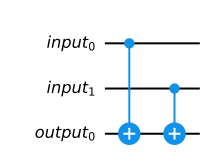

In [22]:
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

この回路は、 `input0 == input1`かどうかをチェックし、出力を`output0`に保存します。各句をチェックするには、 `clause_list`のペアごとにこの回路を繰り返し、出力を新しいビットに保存します。

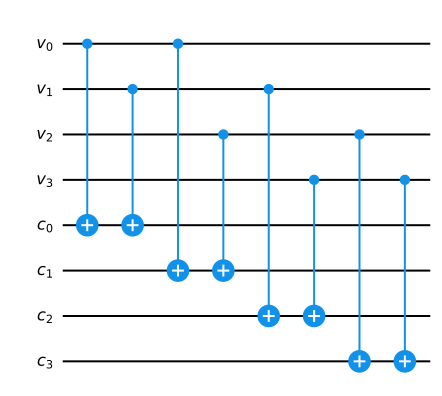

In [23]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()

`c0, c1, c2, c3`の割り当てが数独の解である場合、ビット`v0, v1, v2, v3`の最終状態はすべて`1`になるだけです。チェック回路を完成させるには、すべての条項が満たされる場合 (その場合に限り) 単一ビットを`1`にする必要があります。これにより、1 つのビットだけを調べて、割り当てが解決策であるかどうかを確認できます。これは、複数制御された Toffoli ゲートを使用して行うことができます。

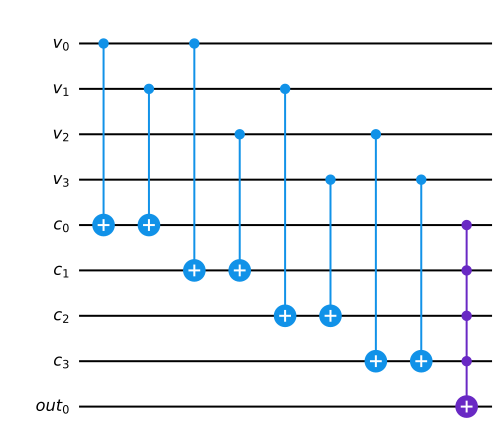

In [24]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw()

上記の回路は、ビット`v0` 、 `v1` 、 `v2`および`v3`の初期割り当てを入力として受け取り、他のすべてのビットは`0`に初期化される必要があります。回路を実行した後、 `out0`ビットの状態によって、この割り当てが解決策であるかどうかがわかります。 `out0 = 0`代入が解で*はないこと*を意味し、 `out0 = 1`は代入が解*であること*を意味します。

**重要:**続行する前に、この回路を十分に理解し、上の段落で説明したとおりに動作することを確信することが重要です。

### 4.1.2 Oracle の計算解除と完成

ここで、[位相キックバック](/course/ch-gates/phase-kickback)を使用して、このチェック回路を Grover オラクルに変えることができます。要約すると、3 つのレジスタがあります。

- sudoku 変数を保存する 1 つのレジスタ ($x = v_3、v_2、v_1、v_0$ とします)
- 句を格納する 1 つのレジスタ (これは $|0000\rangle$ 状態で始まり、$|0\rangle$ と省略します)
- そして、チェック回路の出力を保存するために使用している 1 つの量子ビット ($|\text{out}_0\rangle$) です。

オラクルを作成するには、変換を実行するための回路 ($U_\omega$) が必要です。

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = |x\rangle|0\rangle|\text{out}_0\oplus f(x)\rangle
$$

`out0`量子ビットを重ね合わせ状態 $|{-}\rangle$ に設定すると、次のようになります。

$$
\begin{aligned}
U_\omega|x\rangle|0\rangle|{-}\rangle
&amp;= U_\omega|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&amp;= |x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|0\oplus f(x)\rangle - |1\oplus f(x)\rangle)
\end{aligned}
$$

$f(x) = 0$ の場合、次の状態になります。

$$
\begin{aligned}
&amp;= |x\rangle|0\rangle\otimes \tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&amp;= |x\rangle|0\rangle|-\rangle\\
\end{aligned}
$$

(つまり変化なし)。しかし、$f(x) = 1$ (つまり $x = \omega$) の場合、$|{-}\rangle$ 量子ビットに負の位相を導入します。

$$
\begin{aligned}
&amp;= \phantom{-}|x\rangle|0\rangle\otimes\tfrac{1}{\sqrt{2}}(|1\rangle - |0\rangle)\\
&amp;= \phantom{-}|x\rangle|0\rangle\otimes -\tfrac{1}{\sqrt{2}}(|0\rangle - |1\rangle)\\
&amp;= -|x\rangle|0\rangle|-\rangle\\
\end{aligned}
$$

これは、$|0\rangle|{-}\rangle$ 状態で 2 つの補助レジスタを使用する機能するオラクルです。

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

チェック回路を Grover オラクルに適合させるには、2 番目のレジスタ ( `c` ) のビットが計算後に常に状態 $|0000\rangle$ に返されることを保証する必要があります。これを行うには、回路の実行後に`c0 = c1 = c2 = c3 = 0`保証する節を計算する回路の部分を繰り返すだけです。このステップを*「非計算」*と呼びます。

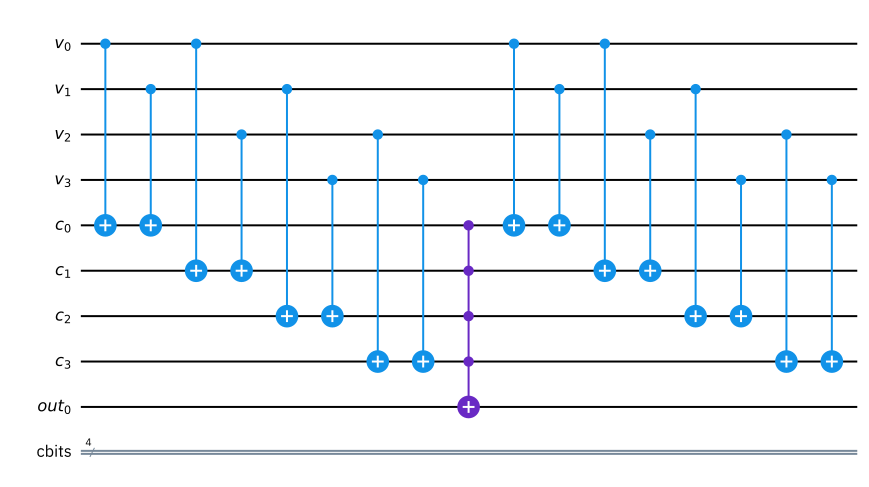

In [25]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()

要約すると、上記の回路は次のことを実行します。

$$
U_\omega|x\rangle|0\rangle|\text{out}_0\rangle = \Bigg\{
\begin{aligned}
|x\rangle|0\rangle|\text{out}_0\rangle \quad \text{for} \; x \neq \omega \\
|x\rangle|0\rangle\otimes X|\text{out}_0\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

$|\text{out}_0\rangle = |{-}\rangle$ の初期状態の場合:

$$
U_\omega|x\rangle|0\rangle|{-}\rangle = \Bigg\{
\begin{aligned}
\phantom{-}|x\rangle|0\rangle|-\rangle \quad \text{for} \; x \neq \omega \\
-|x\rangle|0\rangle|-\rangle \quad \text{for} \; x = \omega \\
\end{aligned}
$$

### 4.1.3 完全なアルゴリズム

あとは、これらすべてのコンポーネントを組み合わせるだけです。

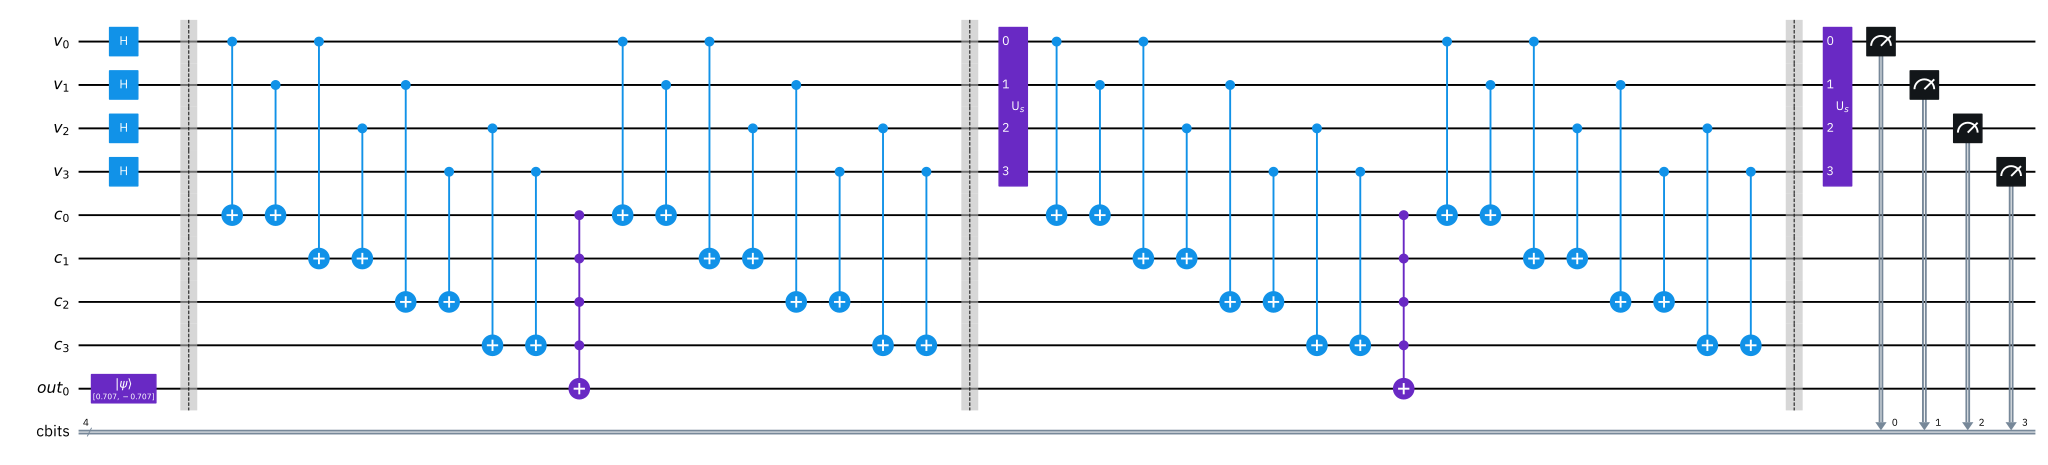

In [26]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)

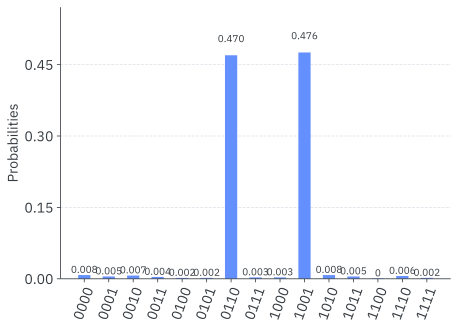

In [27]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())

他のビット列よりも測定確率がはるかに高い 2 つのビット列、 `0110`と`1001`があります。これらは割り当てに対応します。

```
v0 = 0
v1 = 1
v2 = 1
v3 = 0
```

と

```
v0 = 1
v1 = 0
v2 = 0
v3 = 1
```

これが私たちの数独に対する 2 つの解決策です。このセクションの目的は、実際の問題から Grover オラクルを作成する方法を示すことです。この特定の問題は簡単ではありませんが、このプロセスは (十分な規模の回路が可能であれば) あらゆる意思決定問題に適用できます。要約すると、手順は次のとおりです。


&nbsp;

<!-- ::: q-block.exercise -->

### あなたの番

1. 正しい解決策を特定する可逆的な古典的回路を作成する
2. 位相キックバックと非計算を使用して、この回路をオラクルに変えます
3. グローバーのアルゴリズムを使用してこの神託を解決してください

<!-- ::: -->


## 4.2 Grover を使用した三角形発見問題<a id="tri"></a>

[グラフ理論の](gloss:gt)有名な問題の 1 つは[、三角形発見問題](https://en.wikipedia.org/wiki/Triangle-free_graph)です。三角形を見つける問題では、三角形が含まれる場合と含まれない場合があるグラフが与えられます。私たちの仕事は、グラフ内で三角形を見つけて、三角形を形成するノードを指摘することです。たとえば、以下のグラフは、ノード`0` 、 `1` 、および`2`の間に三角形がある 4 ノード グラフです。

![画像12](images/grover_tri.png)

この問題にはグローバーのアルゴリズムを適用できます。アルゴリズムにグラフ内のエッジの*リスト*とノードの数を与えます。あとはアルゴリズムがやってくれます。グラフ内に三角形があるかどうかを確認し、三角形がある場合は、その三角形を形成するノードをマークします。

ここで、Grover のアルゴリズムのステップを見て、三角形発見問題を解決するために各ステップをどのように構築できるかを見てみましょう。まず、エッジのリストである入力を定義しましょう。

In [28]:
#Edges list
edges =[(0, 1), (0, 2), (1, 2), (2, 3)]
#Number of nodes
n_nodes = 4

### 4.2.1 状態の準備

この問題を解決するために、まず上記の例に注目してみましょう。これは、4 ノード グラフで三角形を見つける場合です。そのためには、グラフ内のすべてのサブグラフを調べて、それらのいずれかが三角形かどうかを確認する必要があります。これを行うには 4 量子ビットが必要です。各量子ビットはグラフ内のノードを表します。量子ビットの状態は、ノードがサブグラフ内にあるかどうかを示します。たとえば、上のグラフでは、三角形はノード 0、1、および 2 の間にあり、状態`1110`を使用してこれを言い換えることができます。状態 1 のノードはサブグラフ (三角形) 内にあり、状態 0 のノードはサブグラフ内にありません。

状態を準備するには、すべての可能な状態`0000`から`1111`の重ね合わせを作成する必要があります。これは、 `4`アダマール ゲートを使用して簡単に実行できます。そうすると、オラクルと拡散を`3`回ローテーションする必要があるでしょうか。
しかし、状態内の各`1`アクティブなノードを表す場合、実際にはヒルベルト空間全体を調べる必要はなく、3 つのノードを含むサブグラフを調べるだけで済みます。

これは、別のタイプの対称状態を使用して検索空間を準備する良い例です。ここでは 3 つの 1 を持つ状態のみを考慮する必要があるため、検索空間を形成する別の方法を考えることができます。 3 つのアクティブなノードを持つ状態のみの重ね合わせを作成する 1 つの方法は、W 状態の後に`4 NOT gates`を使用することです。これにより、必要な回転数が`3`から`1`に減少します。

したがって、最初に W ステートを実装する必要があります。 W ステートの形式は次のとおりです。

$$

|W\rangle = {\frac{1}{{\sqrt{n}}}}(|100...0\rangle + ... + |01...0\rangle + |00...01\rangle)

$$

私たちの場合、参考文献 6 で説明されているように $|W_{3}\rangle$ 状態を構築する必要があります。

In [29]:
#We used the W state implementation from W state in reference 6
def control_rotation (qcir,cQbit,tQbit,theta):
    """ Create an intermediate controlled rotation using only unitary gate and controlled-NOT
    
    Args:
    qcir: QuantumCircuit instance to apply the controlled rotation to.
    cQbit: control qubit. 
    tQbit: target qubit.
    theta: rotation angle.
    
    Returns:
    A modified version of the QuantumCircuit instance with control rotation applied.
    
    """
    theta_dash = math.asin(math.cos(math.radians(theta/2)))
    qcir.u(theta_dash,0,0,tQbit)
    qcir.cx(cQbit,tQbit)
    qcir.u(-theta_dash,0,0,tQbit)
    return qcir


def wn (qcir,qbits): 
    """ Create the W-state using the control-rotation function.
    
    Args:
    qcir: QuantumCircuit instance used to construct the W-state.
    qbits: the qubits used to construct the W-state.
    
    Returns:
    A modified version of the QuantumCircuit instance with the W-state construction gates.
    
    """
    for i in range(len(qbits)):
        if i == 0:
            qcir.x(qbits[0])
            qcir.barrier()
        else:
            p = 1/(len(qbits)-(i-1))
            theta = math.degrees(math.acos(math.sqrt(p)))
            theta = 2* theta
            qcir = control_rotation(qcir,qbits[i-1],qbits[i],theta)
            qcir.cx(qbits[i],qbits[i-1])
            qcir.barrier()
    return qcir,qbits

sub_qbits = QuantumRegister(n_nodes)
sub_cir = QuantumCircuit(sub_qbits, name="state_prep")
sub_cir, sub_qbits = wn(sub_cir, sub_qbits)
sub_cir.x(sub_qbits)
stat_prep = sub_cir.to_instruction()
inv_stat_prep = sub_cir.inverse().to_instruction()

### 4.2.2 オラクル

正解を示すのはオラクルです。このような場合、オラクルはすべてのサブグラフを取得し、そのサブグラフ内のエッジの数を数える必要があります。エッジの数が`3`場合は三角形があり、そうでない場合は次のサブグラフに進みます。

![画像13](images/grover_tri_oracle.png)

グラフのエッジごとに 1 つまたは 2 つの`CNOT`ゲートが必要になります。これらの`CNOT`ゲートは 2 つの補助量子ビットに適用され、三角形が見つかった場合は状態`11`になるはずです。三角形には $11_{b}$ という`3 edges`あるため、ここでの補助量子ビットの数は 2 です。次に、オラクルの最後のステップは、もう 1 つの`Toffoli`を適用することです。これは、別の量子ビット`tri_flag`呼びます) の状態を`1`に変更することで三角形が見つかった場合にのみアクティブになります。

&nbsp;

<!-- ::: q-block.reminder -->

### リマインダー


<summary>オラクル</summary>オラクルの仕事は、正しい答えを検証し、マークすることです。したがって、オラクルを構築するときは、基本的に特定の条件を検証する回路を構築することになります。

<!-- ::: -->

In [30]:
def edge_counter(qc,qubits,anc,flag_qubit,k):
    bin_k = bin(k)[2:][::-1]
    l = []
    for i in range(len(bin_k)):
        if int(bin_k[i]) == 1:
            l.append(qubits[i])
    qc.mct(l,flag_qubit,[anc])
    
    
def oracle(n_nodes, edges, qc, nodes_qubits, edge_anc, ancilla, neg_base):
    k = 3 #k is the number of edges, in case of a triangle, it's 3
    #1- edge counter
    #forward circuit
    qc.barrier()
    qc.ccx(nodes_qubits[edges[0][0]],nodes_qubits[edges[0][1]],edge_anc[0])
    for i in range(1,len(edges)):
        qc.mct([nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0]], edge_anc[1], [ancilla[0]])
        qc.ccx(nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0])
    #----------------------------------------------------------------------------------------------------------
     #Edges check Qubit
    edg_k = int((k/2)*(k-1))
    edge_counter(qc,edge_anc,ancilla[0],neg_base[0],edg_k)
    #----------------------------------------------------------------------------------------------------------

    #4- Reverse edge count
    for i in range(len(edges)-1,0,-1):
        qc.ccx(nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0])
        qc.mct([nodes_qubits[edges[i][0]],nodes_qubits[edges[i][1]],edge_anc[0]], edge_anc[1], [ancilla[0]])
    qc.ccx(nodes_qubits[edges[0][0]],nodes_qubits[edges[0][1]],edge_anc[0])
    qc.barrier()

### 4.2.3 拡散演算子

前に述べたように、拡散オペレータの構築は、使用した状態準備のタイプ (この場合は W 状態) に依存します。したがって、拡散オペレータを形成するには、逆の W ステート、マルチ制御 Z ゲート、および元の W ステートが必要です。

In [31]:
def cnz(qc, num_control, node, anc):
    """Construct a multi-controlled Z gate
    
    Args:
    num_control :  number of control qubits of cnz gate
    node :             node qubits
    anc :               ancillaly qubits
    """
    if num_control>2:
        qc.ccx(node[0], node[1], anc[0])
        for i in range(num_control-2):
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.cz(anc[num_control-2], node[num_control])
        for i in range(num_control-2)[::-1]:
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.ccx(node[0], node[1], anc[0])
    if num_control==2:
        qc.h(node[2])
        qc.ccx(node[0], node[1], node[2])
        qc.h(node[2])
    if num_control==1:
        qc.cz(node[0], node[1])

In [32]:
def grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep):
    qc.append(inv_stat_prep,qargs=nodes_qubits)
    qc.x(nodes_qubits)
    #====================================================
        #3 control qubits Z gate
    cnz(qc,len(nodes_qubits)-1,nodes_qubits[::-1],ancilla)
    #====================================================
    qc.x(nodes_qubits)
    qc.append(stat_prep,qargs=nodes_qubits) 

### 4.2.4 すべてをまとめる

アルゴリズムのすべてのコンポーネントを構築して実行したので、それらを組み合わせることができます。

In [33]:
# Grover algo function
def grover(n_nodes,stat_prep,inv_stat_prep):
    #N = 2**n_nodes  # for optimal iterations count if the state prep is done using only H gates.
    N = math.comb(n_nodes, 3) #Since we are using W-state to perform initial preparation.
    nodes_qubits = QuantumRegister(n_nodes, name='nodes')
    edge_anc = QuantumRegister(2, name='edge_anc')
    ancilla = QuantumRegister(n_nodes-2, name = 'cccx_diff_anc')
    neg_base = QuantumRegister(1, name='check_qubits')
    class_bits = ClassicalRegister(n_nodes, name='class_reg')
    tri_flag = ClassicalRegister(3, name='tri_flag')
    qc = QuantumCircuit(nodes_qubits, edge_anc, ancilla, neg_base, class_bits, tri_flag)
    # Initialize qunatum flag qubits in |-> state
    qc.x(neg_base[0])
    qc.h(neg_base[0])
    # Initializing i/p qubits in superposition
    qc.append(stat_prep,qargs=nodes_qubits)
    qc.barrier()
    # Calculate iteration count
    iterations = math.floor(math.pi/4*math.sqrt(N))
    # Calculate iteration count
    for i in np.arange(iterations):
        qc.barrier()
        oracle(n_nodes, edges, qc, nodes_qubits, edge_anc,  ancilla, neg_base)
        qc.barrier()
        grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep)
    qc.measure(nodes_qubits,class_bits)
    return qc

次に、コードを実行してヒストグラムをプロットして、アルゴリズムが期待どおりに機能するかどうかを確認してみましょう。

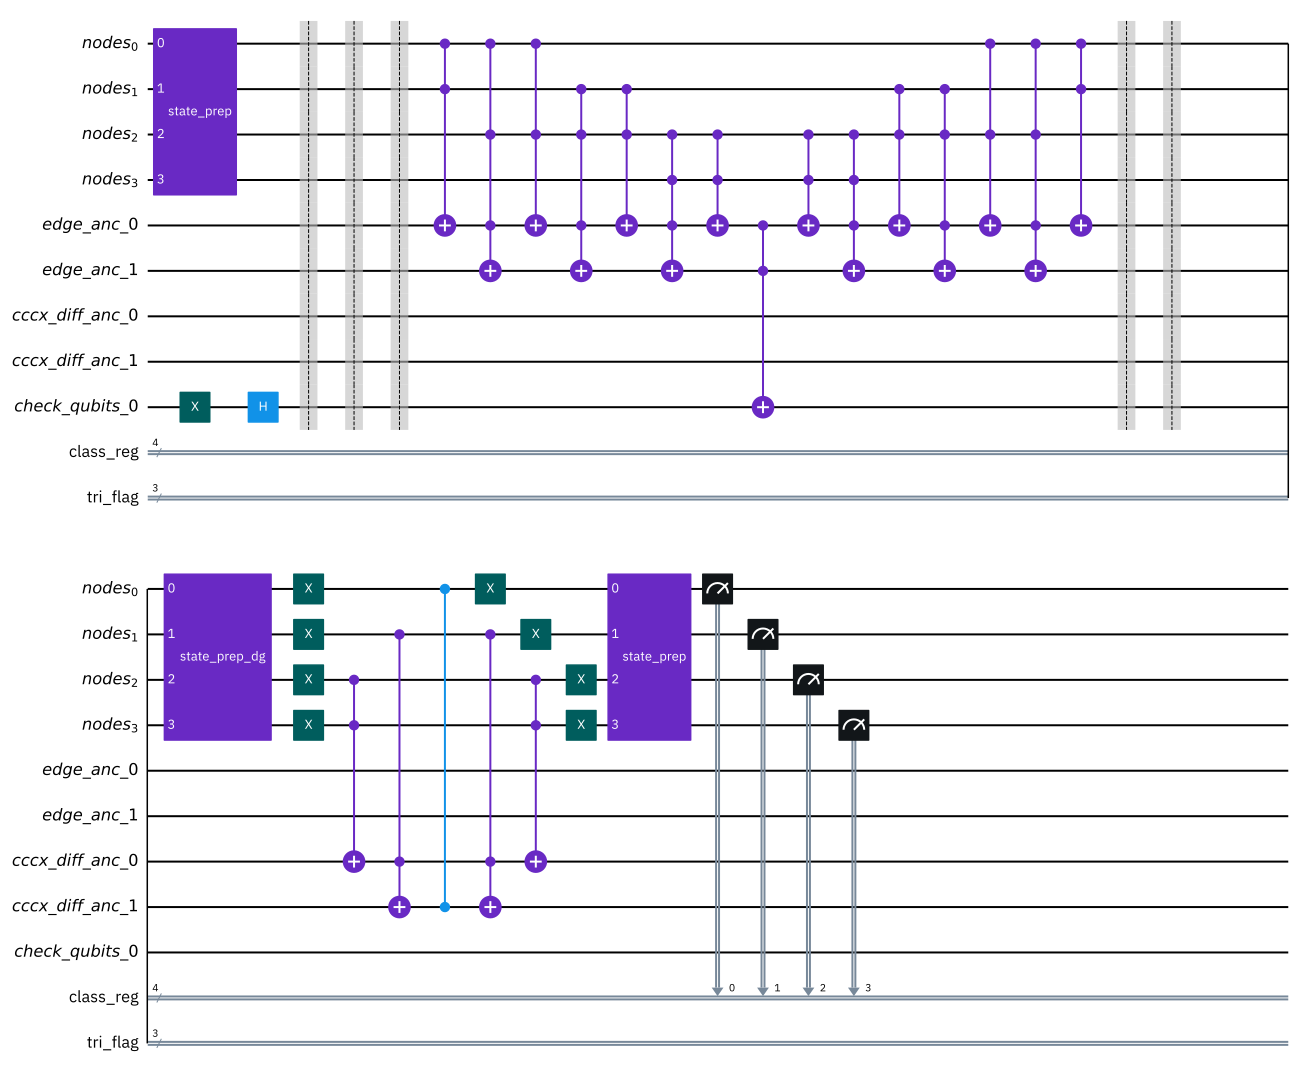

In [34]:
qc = grover(n_nodes,stat_prep,inv_stat_prep)
qc.draw()

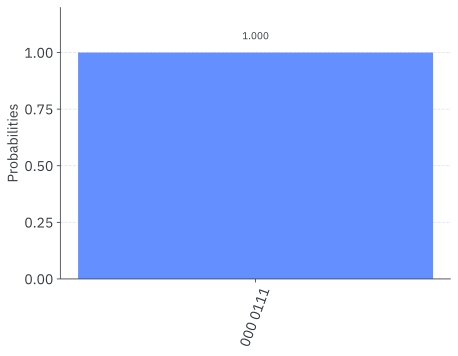

In [35]:
# Simulate and plot results
qasm_simulator = Aer.get_backend('qasm_simulator')
#transpiled_qc = transpile(qc, qasm_simulator)
# Execute circuit and show results
ex = execute(qc, qasm_simulator, shots = 5000)
res = ex.result().get_counts(qc)
plot_histogram(res)

<!-- ::: q-block.exercise -->

### あなたの番

この問題を拡張して、任意のサイズのグラフで三角形を見つけることはできますか?

[IBM Quantum Lab](https://quantum-computing.ibm.com/lab)で試してみる

<!-- ::: -->


## 5. 参考文献<a id="references"></a>

1. LK Grover (1996)、「データベース検索のための高速量子力学アルゴリズム」、コンピューティング理論に関する第 28 回年次 ACM シンポジウム議事録 (STOC 1996)、 [doi:10.1145/237814.237866](http://doi.acm.org/10.1145/237814.237866) 、 [arXiv:quant-ph/9605043](https://arxiv.org/abs/quant-ph/9605043)
2. C. Figgatt、D. Maslov、KA Landsman、NM Linke、S. Debnath &amp; C. Monroe (2017)、「Complete 3-Qubit Grover search on a Programmable quantumcomputer」、Nature Communications、Vol 8、Art 1918、 [doi: 10.1038/s41467-017-01904-7](https://doi.org/10.1038/s41467-017-01904-7) 、 [arXiv:1703.10535](https://arxiv.org/abs/1703.10535)
3. I. Chuang &amp; M. Nielsen、「量子計算と量子情報」、ケンブリッジ: ケンブリッジ大学出版局、2000 年。
4. Marconi, C.、Aloy, A.、Tura, J.、Sanpera, A. (2021)。もつれた対称状態と共正行列。クォンタム、5、561。
5. R. Prevedel、G. Cronenberg、MS Tame、M. Paternostro、P. Walther、MS Kim、および A. Zeilinger、「マルチパーティ量子ネットワーキングのための最大 6 量子ビットのディッケ状態の実験的実現」、Physical Review Letters、vol. 103、いいえ。 2009 年 7 月 2 日。
6. D. クルーズ、R. フルニエ、F. グレミオン、A. ジャンヌロ、K. 駒形、T. トシッチ、J. ティエスブルメル、CL チャン、N. マクリス、M.-A. Dupertuis et al.、「ghz および w 状態の効率的な量子アルゴリズム、および IBM 量子コンピューターでの実装」、Advanced Quantum Technologies、vol. 2、いいえ。 5-6、p.1900015、2019。https://doi.org/10.1002/qute.201900015
7. マニエス F.、サンタ M.、セゲディ M. (2007)。三角形問題の量子アルゴリズム。 SIAM ジャーナル オン コンピューティング、37(2)、413-424。

In [36]:
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
